In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
import time



In [53]:
train = pd.read_csv("data/train.csv")
X_train = train[['comment_text']]
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_x = pd.read_csv("data/test.csv")
X_test = test_x[['id', 'comment_text']]
test_y = pd.read_csv("data/test_labels.csv")
y_test = test_y[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

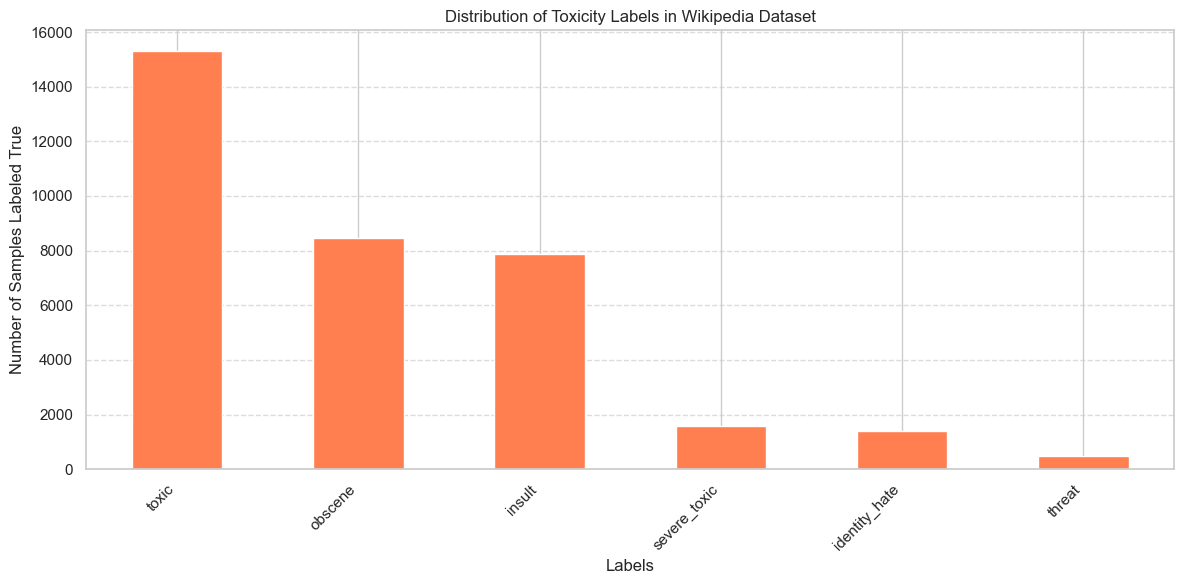

In [71]:
label_cols = [col for col in y_train]

# Count how many times each label is True
label_counts = y_train[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='coral')
plt.title('Distribution of Toxicity Labels in Wikipedia Dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Samples Labeled True')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [54]:
y_test_filtered = y_test[~(y_test == -1).any(axis=1)]
X_test_filtered = X_test.merge(y_test_filtered[['id']], on='id')

X_test = X_test_filtered.drop(columns='id')
y_test = y_test_filtered.drop(columns='id')
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (159571, 1), y_train shape: (159571, 6), X_test shape: (63978, 1), y_test shape: (63978, 6)


In [6]:
import re
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = set(stopwords.words("english"))

def tokenize_text(text):
    text = text.lower()
    
    # Remove URLs, special chars
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-zA-Z\s]", "", text)
    
    # Tokenize + Remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc]
    
    return " ".join(lemmatized) 

In [9]:
print("Preprocessing text...")
X_train_preprocessed = X_train.apply(tokenize_text)

Preprocessing text...


In [9]:
test_x.shape

(153164, 2)

In [42]:
X_train.head()

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


In [43]:
tfidf = TfidfVectorizer(
    max_features=5000,  
    stop_words='english', 
    ngram_range=(1, 2)  
)

models = {
    "MultinomialNB": MultiOutputClassifier(MultinomialNB()),
    "LogisticRegression": MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    "LinearSVC": MultiOutputClassifier(LinearSVC(max_iter=1000)),
    "XGBoost": MultiOutputClassifier(XGBClassifier(eval_metric='logloss')),
}

In [11]:
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
}

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

In [18]:
for name, model in models.items():
    print(f"Evaluating {name}...")
    start = time.time()
    pipeline = make_pipeline(tfidf, model)
    
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train_preprocessed.iloc[train_idx], X_train_preprocessed.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        pipeline.fit(X_fold_train, y_fold_train)
        y_pred = pipeline.predict(X_fold_val)
        
        f1_scores.append(f1_score(y_fold_val, y_pred, average='micro'))
        precision_scores.append(precision_score(y_fold_val, y_pred, average='micro'))
        recall_scores.append(recall_score(y_fold_val, y_pred, average='micro'))

    end = time.time()
    results[name] = {
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores),
        'Training Time (s)': end-start,
    }
    print(f"Time taken: {end-start}")

results_df = pd.DataFrame(results).T

Evaluating MultinomialNB...
Time taken: 37.55409812927246
Evaluating LogisticRegression...
Time taken: 44.38541507720947
Evaluating LinearSVC...
Time taken: 47.19519329071045
Evaluating XGBoost...
Time taken: 253.4261119365692


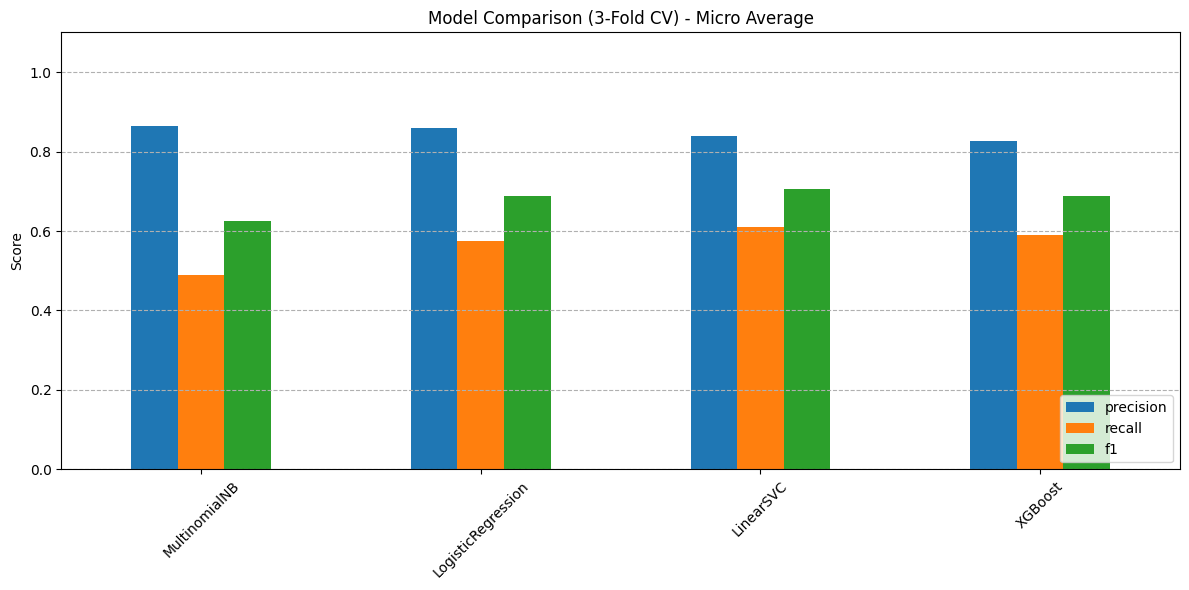

In [19]:
metrics = ['precision', 'recall', 'f1']
results_df[metrics].plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison (3-Fold CV) - Micro Average")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [20]:
results_df

,precision,recall,f1,Training Time (s)
MultinomialNB,0.864245,0.488775,0.624363,37.554098
LogisticRegression,0.860085,0.573854,0.688365,44.385415
LinearSVC,0.839339,0.610493,0.706823,47.195193
XGBoost,0.825277,0.590846,0.688612,253.426112


In [50]:
y_test['toxic'].unique()

array([-1,  0,  1])

In [57]:
X_train_tfidf = tfidf.fit_transform(X_train['comment_text'])
X_test_tfidf = tfidf.transform(X_test['comment_text'])
y_train.head()
metrics_results = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Training time': [],
}

for name, model in models.items():
    print(f"Training {name}...")
    start = time.time()
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    training_time = time.time() - start
    print(f"Training took {training_time}")

    metrics_results['Model'].append(name)
    metrics_results['Precision'].append(precision)
    metrics_results['Recall'].append(recall)
    metrics_results['F1 Score'].append(f1)
    metrics_results['Training time'].append(training_time)

results_df = pd.DataFrame(metrics_results)

Training MultinomialNB...
Training took 0.12351799011230469
Training LogisticRegression...
Training took 1.5287981033325195
Training LinearSVC...
Training took 3.154419422149658
Training XGBoost...
Training took 58.170910120010376


In [58]:
results_df

,Model,Precision,Recall,F1 Score,Training time
0,MultinomialNB,0.689395,0.491930,0.567238,0.123518
1,LogisticRegression,0.659333,0.607808,0.624282,1.528798
2,LinearSVC,0.626686,0.644296,0.627873,3.154419
3,XGBoost,0.609573,0.617464,0.611013,58.170910


In [61]:
yt_toxic_df = pd.read_csv('data/youtoxic_english_1000.csv')
yt_toxic_df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


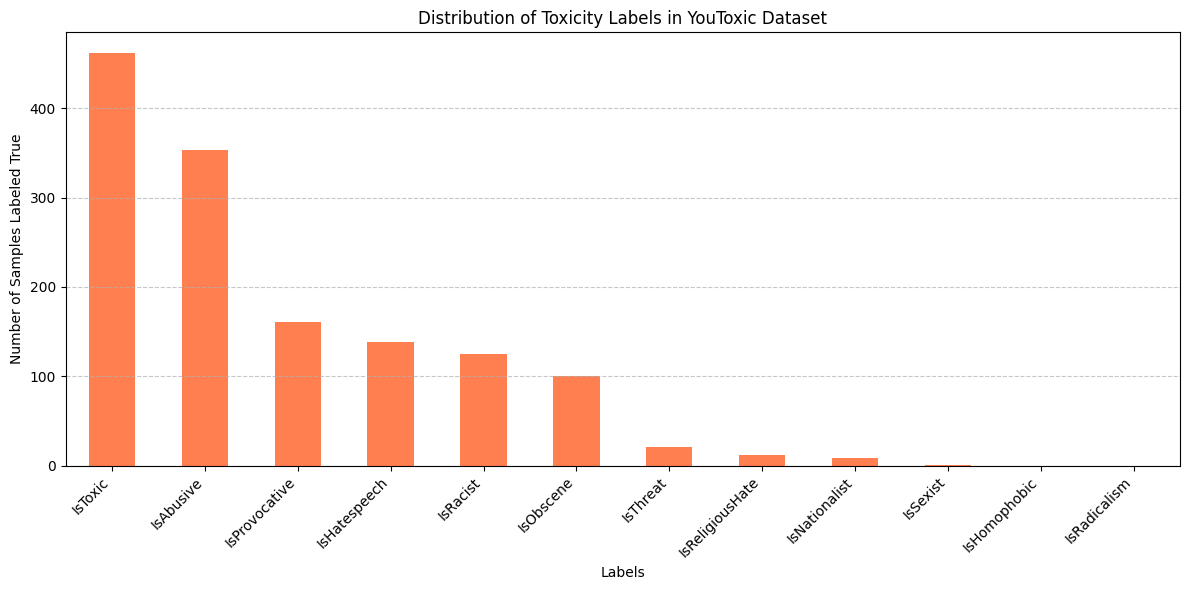

In [62]:
# Select columns that start with "Is" (all label columns)
label_cols = [col for col in yt_toxic_df.columns if col.startswith("Is")]

# Count how many times each label is True
label_counts = yt_toxic_df[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='coral')
plt.title('Distribution of Toxicity Labels in YouToxic Dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Samples Labeled True')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [63]:
df = pd.read_csv('data/ruddit_comments_score.csv')
df.head()

,comment_id,body,score
0,cza1q49,> The difference in average earnings between m...,-0.083
1,cza1wdh,"The myth is that the ""gap"" is entirely based o...",-0.022
2,cza23qx,[deleted],0.167
3,cza2bw8,The assertion is that women get paid less for ...,-0.146
4,cza2iji,You said in the OP that's not what they're mea...,-0.083


You should consider upgrading via the '/Users/potus/toxic_comments_classifier/.venv/bin/python3 -m pip install --upgrade pip' command.


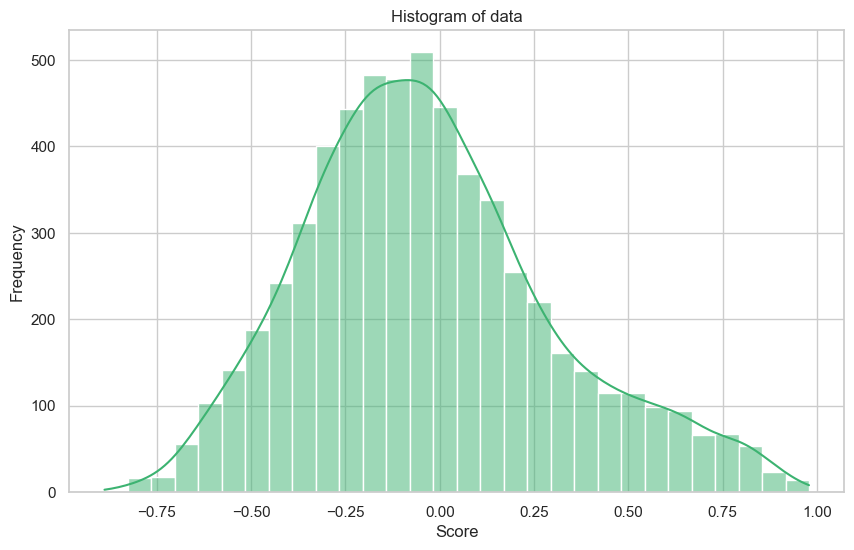

In [68]:
!pip install seaborn
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df['score'], bins=30, kde=True, color='mediumseagreen')
plt.title('Histogram of data')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [70]:
df.shape

(5966, 3)